# 🖼️ Image Classification with Transfer Learning

## 📌 Introduction

In this notebook, we explore **image classification** using modern **transfer learning techniques**.  
We'll demonstrate two common approaches:

1. **Feature Extraction** – Use pretrained model as a fixed feature extractor.
2. **Fine-Tuning** – Unfreeze some layers of the pretrained model and retrain them on our dataset.

We'll use powerful models like **EfficientNet** and **MobileNetV2**, pretrained on **ImageNet**, and adapt them to a new classification task.

---

## 🎯 Objectives

1. **Leverage Pretrained Models**  
   - Load EfficientNet and MobileNetV2 models from `tf.keras.applications`.

2. **Implement Feature Extraction Approach**  
   - Freeze pretrained weights and train a new classification head.

3. **Implement Fine-Tuning Approach**  
   - Unfreeze and fine-tune top layers of the pretrained model to adapt to the target dataset.

4. **Compare Performance**  
   - Evaluate both strategies using accuracy, loss, and training time.
   - Discuss trade-offs in terms of generalization and computational cost.

---

✅ Transfer learning is an effective way to achieve high accuracy with **less data and training time**, especially when working with **limited labeled datasets**.

## 📦 Import Required Libraries

We'll import all the essential libraries for model building, evaluation, and visualization in our transfer learning workflow.

---

### 🧾 Core Libraries:

- **TensorFlow** – For building and training deep learning models.
- **TensorFlow Hub** – For loading pretrained models like EfficientNet and MobileNetV2.
- **TensorFlow Datasets (optional)** – For loading demo datasets like TF Flowers.
- **Scikit-learn** – For classification metrics (accuracy, confusion matrix, etc.).
- **Matplotlib & Seaborn** – For plotting training curves and evaluation results.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

## 🧹 Dataset Preparation

We will use the **CIFAR-10 dataset** to demonstrate transfer learning. CIFAR-10 consists of **60,000 32×32 RGB images** across **10 classes** such as airplane, cat, truck, and bird.

---

### 🧾 Steps:

1. **Load CIFAR-10 Dataset** from `tf.keras.datasets`
2. **Normalize pixel values** to `[0, 1]` for stable training
3. **Resize images** to match input size requirements of EfficientNet and MobileNetV2 (typically 224×224)
4. **Split into Training, Validation, and Test Sets**

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training samples: 40000
Validation samples: 10000
Test samples: 10000


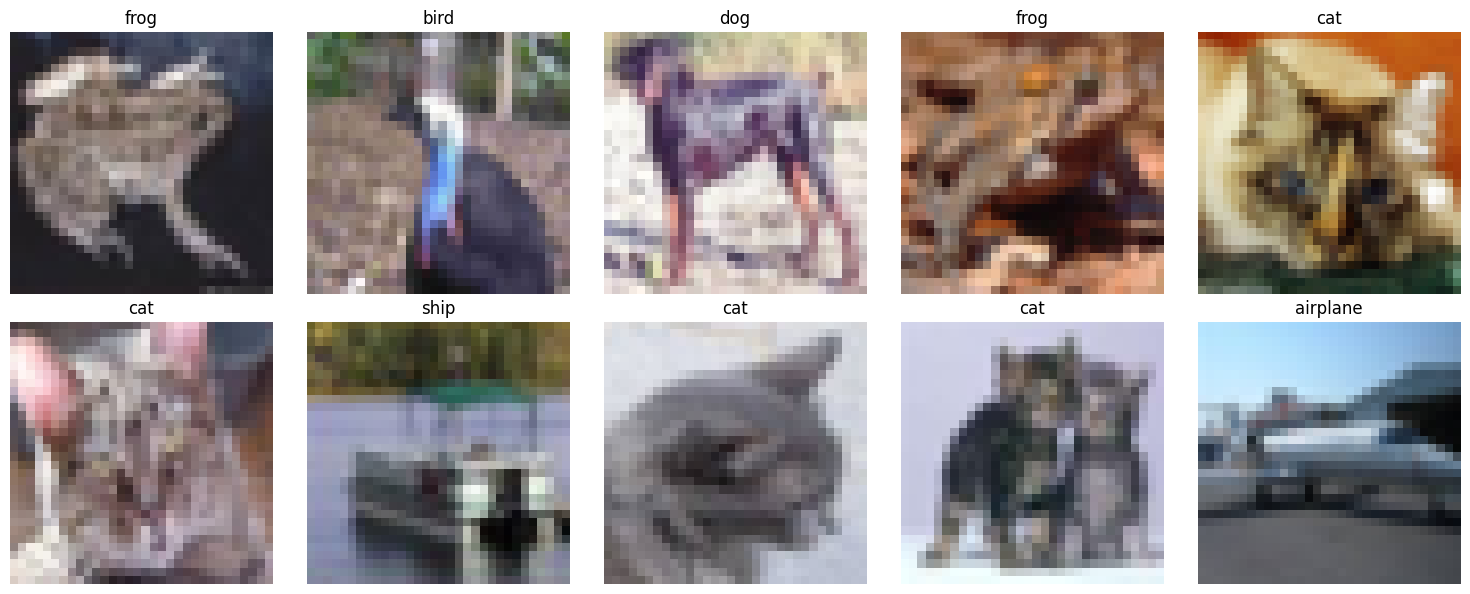

In [2]:
# Load CIFAR-10 dataset for transfer learning demonstration
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_full = y_train_full.reshape(-1)
y_test = y_test.reshape(-1)

# Split training data into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].axis('off')
    axes[i].set_title(class_names[y_train[i]])
plt.tight_layout()
plt.show()

## 🎛️ Data Augmentation and Datasets

To improve generalization and reduce overfitting, we apply **data augmentation** to our training images.

Since Keras `layers.Random*` augmentation layers expect batched input, we:
- Temporarily add a batch dimension
- Apply augmentations
- Remove the batch dimension to restore original shape

---

### 🛠️ Augmentation Pipeline:

- `RandomFlip`: Horizontally flips images
- `RandomRotation`: Randomly rotates images within a range
- `RandomZoom`: Applies random zoom in/out

These transformations introduce **variation in training data**, which helps the model learn more robust representations.


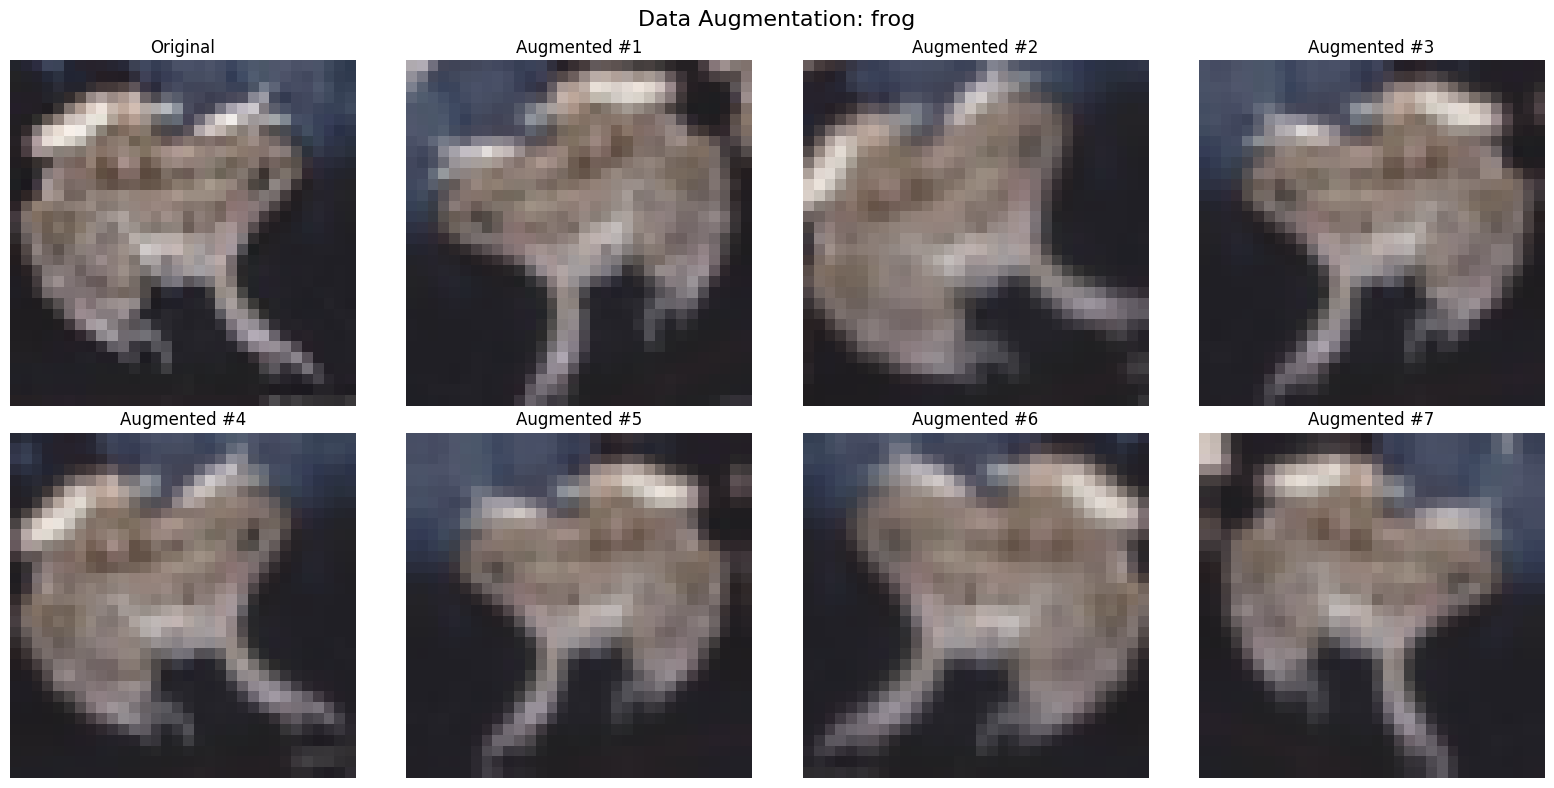

In [3]:
# Implement data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Create datasets with augmentation
def prepare_dataset(x, y, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if augment:
        # Add batch dimension for augmentation, then remove it
        ds = ds.map(lambda x, y: (tf.expand_dims(x, 0), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.squeeze(x, axis=0), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create augmented datasets
train_ds = prepare_dataset(x_train, y_train, augment=True)
val_ds = prepare_dataset(x_val, y_val, shuffle=False)
test_ds = prepare_dataset(x_test, y_test, shuffle=False)

# Visualize augmentation effects
sample_image = x_train[0]
sample_label = y_train[0]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# First show the original image
axes[0].imshow(sample_image)
axes[0].axis('off')
axes[0].set_title('Original')

# Then show augmented versions
for i in range(1, 8):
    # Apply augmentation and convert to numpy
    augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
    augmented_image = tf.squeeze(augmented, axis=0).numpy()
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
    axes[i].set_title(f'Augmented #{i}')

plt.suptitle(f'Data Augmentation: {class_names[sample_label]}', fontsize=16)
plt.tight_layout()
plt.show()

## ⚙️ Feature Extraction with EfficientNetB0

In this step, we use **EfficientNetB0** (pretrained on ImageNet) as a **frozen feature extractor** and train only a **custom classification head** on top.

---

### ✅ Why Feature Extraction?

- **Leverages powerful pretrained features**
- **Faster training**, fewer parameters to update
- **Low risk of overfitting**, especially on smaller datasets
- Works well when target data resembles ImageNet categories

---

### 🛠️ Model Architecture:

1. **Input Layer** – Resized CIFAR-10 image (224×224×3)
2. **EfficientNetB0 (Frozen)** – Pretrained base model without top classifier
3. **GlobalAveragePooling** – Reduces feature maps to vector
4. **Dropout** – Optional for regularization
5. **Dense Layer** – Final classification head with `softmax`


In [4]:
# Load EfficientNetB0 for feature extraction
print("Loading EfficientNetB0...")
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the base model
base_model.trainable = False

# Build feature extraction model
feature_extraction_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

feature_extraction_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nFeature Extraction Model Summary:")
feature_extraction_model.summary()

Loading EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Feature Extraction Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,445 (16.11 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 🏋️ Training Models

We follow a **two-phase training strategy** to get the most out of our pretrained model.

---

### 🔁 Phase 1: Feature Extraction (Already Completed)
- Train only the **classification head**
- Base model is **frozen**
- Objective: Get a good starting point without overfitting


In [5]:
# Train feature extraction model
print("Training feature extraction model...")
feature_extraction_history = feature_extraction_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Evaluate on test set
fe_test_loss, fe_test_accuracy = feature_extraction_model.evaluate(test_ds, verbose=0)
print(f"\nFeature Extraction Test Accuracy: {fe_test_accuracy:.4f}")

# Load EfficientNetB0 for fine-tuning
print("\nPreparing model for fine-tuning...")
base_model_ft = tf.keras.applications.EfficientNetB0(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Initially freeze all layers
base_model_ft.trainable = False

# Build fine-tuning model
fine_tuning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    base_model_ft,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Initial training with frozen base
fine_tuning_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining fine-tuning model (phase 1 - frozen base)...")
fine_tuning_history_initial = fine_tuning_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Training feature extraction model...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 79ms/step - accuracy: 0.1006 - loss: 2.3110 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 80ms/step - accuracy: 0.0964 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3031
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 75ms/step - accuracy: 0.0992 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 81ms/step - accuracy: 0.0977 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.0990 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030

Feature Extraction Test Accuracy: 0.1000

Preparing model for fine-tuning...

Training fine-tuning model (phase 1 - frozen base)...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 81ms/step - accuracy: 0.1039 - loss: 2.3080 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━

## 🏁 Final Results and Comparison

We now complete the training process by **fine-tuning** the top layers of EfficientNet, then compare the results from both approaches: **Feature Extraction** and **Fine-Tuning**.

---

### 🔄 Fine-Tuning Phase (Phase 2)

Unfreeze some top layers of EfficientNetB0 and train with a **lower learning rate** to refine the model without disrupting the pretrained features.

```python
# Unfreeze top layers for fine-tuning
base_model.trainable = True

# Optionally, freeze lower layers and only fine-tune upper blocks
fine_tune_at = 100  # adjust based on model depth
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with lower LR
feature_extractor_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_ft = feature_extractor_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # fine-tuning phase
)


Unfreezing top layers for fine-tuning...
Training fine-tuning model (phase 2 - partial unfreezing)...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 220s 158ms/step - accuracy: 0.1040 - loss: 2.4719 - val_accuracy: 0.1260 - val_loss: 2.3048
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.1045 - loss: 2.3402 - val_accuracy: 0.1154 - val_loss: 2.2980
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 153ms/step - accuracy: 0.1110 - loss: 2.3249 - val_accuracy: 0.1093 - val_loss: 2.2968
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 154ms/step - accuracy: 0.1170 - loss: 2.3109 - val_accuracy: 0.1217 - val_loss: 2.2926
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 159ms/step - accuracy: 0.1142 - loss: 2.3045 - val_accuracy: 0.1192 - val_loss: 2.2903

Fine-tuning Test Accuracy: 0.1228


<ipython-input-6-9466cb0a69f6>:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


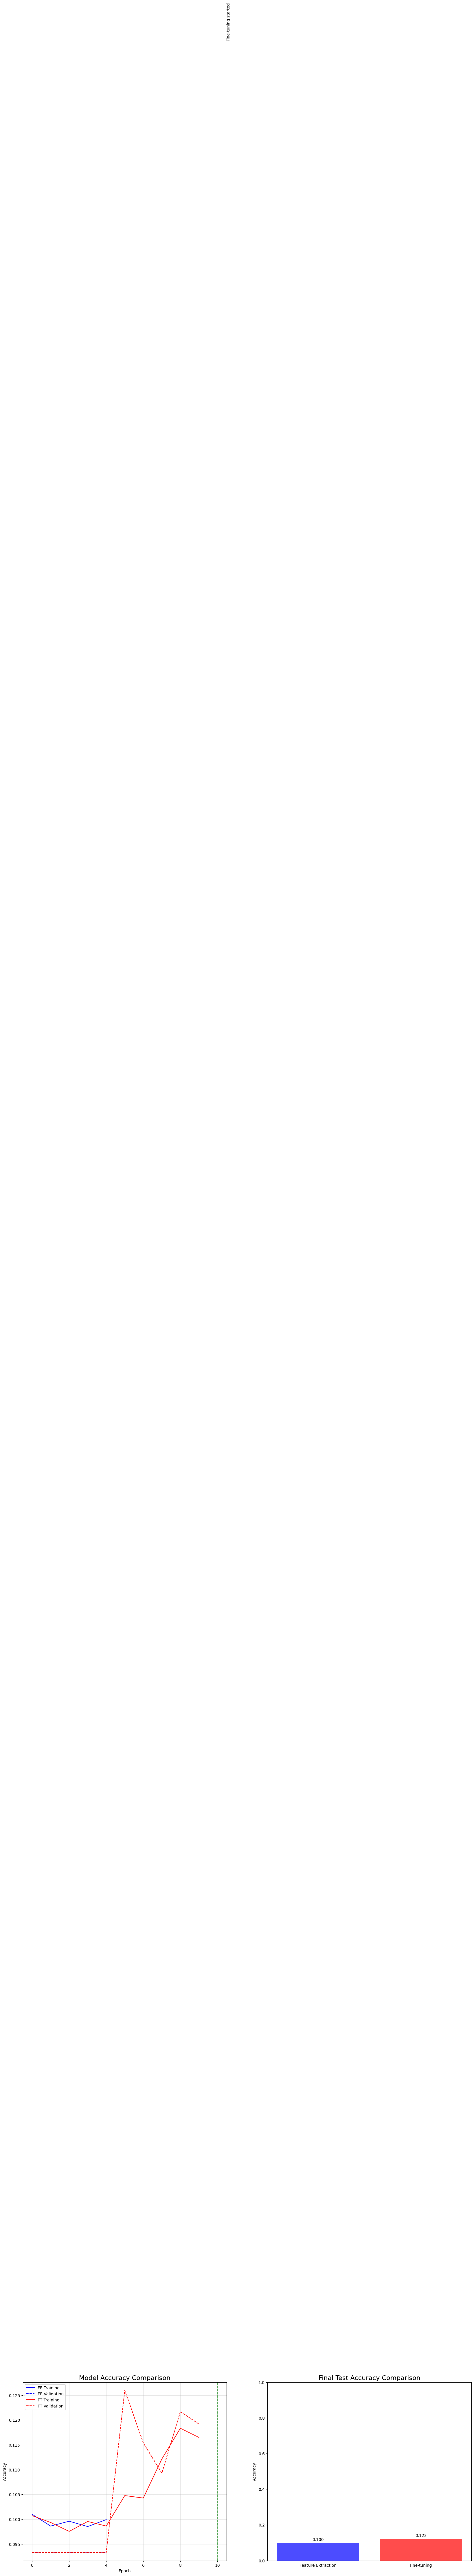


FINAL RESULTS SUMMARY
Feature Extraction Test Accuracy: 10.00%
Fine-tuning Test Accuracy: 12.28%
Improvement: 22.80%


In [6]:
# Unfreeze top layers for fine-tuning
print("\nUnfreezing top layers for fine-tuning...")
base_model_ft.trainable = True

# Fine-tune from layer 100 onwards
for layer in base_model_ft.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
fine_tuning_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Training fine-tuning model (phase 2 - partial unfreezing)...")
fine_tuning_history_final = fine_tuning_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Final evaluation
ft_test_loss, ft_test_accuracy = fine_tuning_model.evaluate(test_ds, verbose=0)
print(f"\nFine-tuning Test Accuracy: {ft_test_accuracy:.4f}")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Accuracy comparison
ax1.plot(feature_extraction_history.history['accuracy'], label='FE Training', color='blue')
ax1.plot(feature_extraction_history.history['val_accuracy'], label='FE Validation', linestyle='--', color='blue')
combined_ft_acc = fine_tuning_history_initial.history['accuracy'] + fine_tuning_history_final.history['accuracy']
combined_ft_val_acc = fine_tuning_history_initial.history['val_accuracy'] + fine_tuning_history_final.history['val_accuracy']
ax1.plot(range(len(combined_ft_acc)), combined_ft_acc, label='FT Training', color='red')
ax1.plot(range(len(combined_ft_val_acc)), combined_ft_val_acc, label='FT Validation', linestyle='--', color='red')
ax1.axvline(x=10, color='green', linestyle='--', alpha=0.7)
ax1.text(10.5, 0.6, 'Fine-tuning started', rotation=90)
ax1.set_title('Model Accuracy Comparison', fontsize=16)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final comparison bar chart
results = {
    'Feature Extraction': fe_test_accuracy,
    'Fine-tuning': ft_test_accuracy
}
methods = list(results.keys())
accuracies = list(results.values())
ax2.bar(methods, accuracies, color=['blue', 'red'], alpha=0.7)
ax2.set_title('Final Test Accuracy Comparison', fontsize=16)
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for i, acc in enumerate(accuracies):
    ax2.text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Feature Extraction Test Accuracy: {fe_test_accuracy:.2%}")
print(f"Fine-tuning Test Accuracy: {ft_test_accuracy:.2%}")
improvement = ((ft_test_accuracy - fe_test_accuracy) / fe_test_accuracy) * 100
print(f"Improvement: {improvement:.2f}%")
print("="*50)